# Zestaw 8. Dekompozycja spektralna

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from random import randint
from scipy.linalg import lu_factor, lu_solve

## 1. Metoda potęgowa

<i>Napisz funkcję obliczającą metodą potęgową dominującą wartość własną (największą co do modułu) i odpowiadający jej wektor własny dla danej macierzy rzeczywistej symetrycznej. Sprawdź automatycznie poprawność działania programu porównując wyniki (dominująca wartość własna i odpowiadający jej wektor własny) własnej implementacji z funkcją biblioteczną.</i>

In [2]:
def norm(x):
    '''returns max value of x'''
    return np.linalg.norm(x, np.inf)

def normalize(x):
    '''returns normlaized vector x'''
    return x/norm(x)

In [3]:
def power_method(A, epsilon=1e-8, max_iteration=100):
    n = A.shape[0]
    prev_x = np.ones(n)
    x = A @ prev_x
    
    max_x = norm(x)
    x = normalize(x)
    iteration = 1
    
    while iteration < max_iteration and norm(x - prev_x) > epsilon and not np.allclose(x, -prev_x, atol=epsilon):
        x, prev_x = A @ x, x
        max_x = norm(x)
        x = normalize(x)
        iteration += 1
        
    return max_x, x, iteration

Funkcje testujemy dla macierzy symetrycznych, aby mieć pewność, że istnieją wartości i wektory własne.

In [4]:
A = np.random.rand(4, 4)
A = A + A.T

print(A)

[[1.58346629 1.42777846 0.5646072  1.21346048]
 [1.42777846 0.2235879  1.74780389 1.47368988]
 [0.5646072  1.74780389 1.81376915 0.9086156 ]
 [1.21346048 1.47368988 0.9086156  0.56824204]]


In [5]:
def test_power(A):
    eigenvalue, eigenvector, i = power_method(A)
    np_eigenvalue, np_eigenvector = max(np.linalg.eig(A)[0]), normalize(np.linalg.eig(A)[1][:, 0])

    print('iterations count: ', i, '\n')

    print('found eigenvalue: ', eigenvalue)
    print('numpy eigenvalue: ', np_eigenvalue, '\n')

    print('found eigenvector: ', eigenvector)
    print('numpy eigenvector: ', np_eigenvector, '\n')

    print("correct?", 
         np.isclose(eigenvalue, np_eigenvalue) and
        (np.allclose(eigenvector, np_eigenvector)
         or np.allclose(eigenvector, -np_eigenvector)))

In [6]:
test_power(A)

iterations count:  14 

found eigenvalue:  4.738101717384302
numpy eigenvalue:  4.738101705631079 

found eigenvector:  [0.92388982 0.9475564  1.         0.82164004]
numpy eigenvector:  [0.92388982 0.9475564  1.         0.82164004] 

correct? True


Długość wektora własnego nie ma znaczenia, jeśli tenże wektor pomnożymy przez skalar to otrzymany wektor nadal jest wektorem własnym. W związku z tym, dominujący wektor otrzymany funkcją biblioteki numpy również normalizuję, aby można było go łatwo porównać z wynikiem metody potęgowej. Wektory otrzymane dwoma metodami są sobie równe z dokładnością do znaku wektora, dlatego porównując sprawdzam czy są sobier bliskie wektory, ale również jeden wektor z wektorem przeciwnym do drugiego. Wynik jest poprawny z zadaną dokładnością.

<i>Przedstaw na wykresie zależność czasu obliczeń obu implementacji od rozmiaru macierzy (rozmiary macierzy NxN gdzie N = range(100, 2500, 100)). Opisz i zinterpretuj wyniki.</i>

In [9]:
def plot_times():
    ns = list(range(100, 2500, 100))
    power_times = []
    np_times = []
    
    for n in ns:
        A = np.random.rand(n, n)
        A = A + A.T
        
        start = time()
        power_method(A)
        end = time()
        power_times.append(end-start)
        
        start = time()
        np.linalg.eig(A)
        end = time()
        np_times.append(end-start)
    
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.set_xlabel('n - matrix size [1]')
    ax.set_ylabel('t - time[s]')
    
    ax.plot(ns, power_times, marker='o', linewidth=3, color='yellow', label='power iteration method')
    ax.plot(ns, np_times, marker='o', linewidth=3, color='cornflowerblue', label='np.linalg.eig')
    
    plt.legend()
    plt.show()

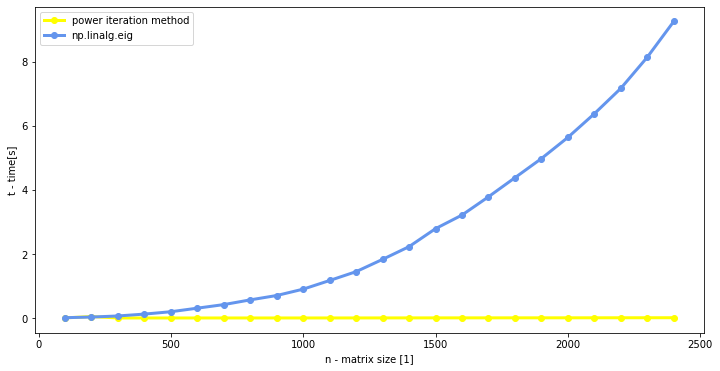

In [10]:
plot_times()

Zaimplementowana metoda potęgowa znajduje dominującą wartość i wektor własny dużo szybciej niż funkcja biblioteczna. Wynika to głównie z faktu, iż funkcja z biblioteki numpy zwraca wszystkie wartości i wektory własne, a wyżej zaimplementowana funkcja tylko jedną wartość i związany z nią wektor.

## 2. Odwrotna metoda potęgowa

<i>Opierając się na twierdzeniu o transformacji widma macierzy oraz wykorzystując metodę potęgową i faktoryzację LU zaimplementuj odwrotną metodę potęgową pozwalającą na szybkie znalezienie wektorów własnych macierzy A, dla wartości σ bliskich odpowiedniej wartości własnej. Wykorzystaj fakt, że mnożenie wektora $x_i$ przez macierz $A^{−1}$ odpowiada rozwiązaniu układu równań $Ax_{i+1} = x_i$.

Opisz poszczególne kroki algorytmu i zinterpretuj wyniki. </i>

Kroki algorytmu:
* Modyfikuję macierz A, odejmując od wartości na przekątnych wartość sigma. Sigma to liczba bliska wybranej wartości własnej.
* Dokonuję faktoryzacji LU dla zmodyfikowanej macierzy A.
* Procedurę można rozpocząć od dowolnego niezerowego wektora x o wymiarach zgodnych z rozmiarem macierzy, ja zaczynam od wektora wypełnionego samymi jedynkami.
* Iteracyjnie zmieniam wektor x, znajdując jego nową wartość jako rozwiązanie równania $Ax_{nowe} = x_{stare}$. Do szybkiego rozwiązania układu wykorzystuję wyliczone na początku macierze L i U.
* Przy każdej iteracji znajduję maksymalną wartość bezwzględną w wektorze x, a następnie normalizuję wektor, dzieląc przez tę wartość.
* Maksymalna wartość bezwględna dąży do wartości własnej macierzy odwrotnej do $(A-\sigma I)$. Korzystając z twierdzenia o transformacji widma macierzy, wyznaczam wartość własną macierzy A jako $\frac{1}{max} + \sigma$. Z tego samego twierdzenia wiem, że uzyskany wektor własny macierzy $(A-\sigma I)^{-1}$ jest też wektorem własnym macierzy A.
* Iterowanie kończę, gdy maksymalna zmiana w wartościach wektora jest mniejsza od zadanego epsilon lub gdy przekroczono limit liczby iteracji.

In [60]:
def inverse_power(A, sigma, epsilon=1e-4, max_iteration=100):
    n = A.shape[0]
    A = A - sigma*np.eye(n)
    lu, piv = lu_factor(A)
    
    prev_x = np.ones(n)
    x = lu_solve((lu, piv), prev_x)
    
    max_x = norm(x)
    x = normalize(x)
    
    iteration = 1
    
    while iteration < max_iteration and norm(x - prev_x) > epsilon and not np.allclose(x, -prev_x, atol=epsilon):
        x, prev_x = lu_solve((lu, piv), x), x
        max_x = norm(x)
        x = normalize(x)
        
        iteration += 1
        
    return 1/(max_x) + sigma, x, iteration

In [65]:
def test_inverse(A, sigma, method):
    value, vector, iterations = method(A, sigma)
    print('iterations: ', iterations, '\n')
    
    np_values, np_vectors = np.linalg.eig(A)

    closest = min(range(len(np_vectors)), key=lambda i: abs(np_values[i] - sigma))
    
    np_value, np_vector = np_values[closest], normalize(np_vectors[:, closest])
    
    print('sigma: ', sigma)
    
    print('found eigenvalue: ', value)
    print('numpy eigenvalue: ', np_values[closest], '\n')

    print('found eigenvector: ', vector)
    print('numpy eigenvector: ', np_vector, '\n')

    print("correct?", np.isclose(value, np_value) and
        (np.allclose(vector, np_vector, atol=1e-4)
         or np.allclose(vector, -np_vector, atol=1e-4)))
    
#     print('\nall:\tvalue\t\t\tvector')
#     for i in range(len(np_vectors)):
#         print(f'\t{np_values[i]}\t{normalize(np_vectors[:, i])}')

In [66]:
test_inverse(A, 4, inverse_power)

iterations:  7 

sigma:  4
found eigenvalue:  4.738085350321124
numpy eigenvalue:  4.738101705631079 

found eigenvector:  [0.92388164 0.94755235 1.         0.82163492]
numpy eigenvector:  [0.92388982 0.9475564  1.         0.82164004] 

correct? True


Metoda poprawnie i bardzo szybko odnalazła wektor własny zadanej macierzy. Dodatkowo znalazła powiązaną z nim wartość własną najbliższą zadanemu sigma. Ważne było poprawne dobranie wartości sigma, której jednak nie zawsze jesteśmy w stanie przewidzieć.

## 3. Iteracje z ilorazem Rayleigha

<i> Zaimplementuj iteracyjną metodę wyznaczania wartości własnej i skojarzonego z nią wektora własnego wykorzystując odwróconą metodę potęgową oraz iloraz Rayleigha. Porównaj zbieżność metody ze zbieżnością algorytmu potęgowego (macierz symetryczna rzeczywista). Opisz poszczególne kroki algorytmu i zinterpretuj wyniki. </i>

Kroki algorytmu:
* W tej metodzie postępuję tak samo jak w odwrotnej metodzie potęgowej, jednak sigma zmienia się w każdej iteracji.
* Sigmę obliczam podstawiając aktualny wektor do funkcji r(x).
* Przy każdej iteracji muszę zmodyfikować macierz iteracji odejmując od początkowego A wartość nowej sigmy na diagonali.
* Przez to, że macierz się zmienia, znajdowanie faktoryzacji LU musiałoby odbywać się przy każdej iteracji, co nie jest wydajne, dlatego nie użyłem tej metody i zamiast tego znajduję rozwiązanie równania macierzowego za pomocą funkcji biblioteki numpy.

In [14]:
def inverse_rayleigh(A, sigma, epsilon=1e-4, max_iteration=100):
    n = A.shape[0]
    M = A - sigma*np.eye(n)
    
    prev_x = np.ones(n)
    x = np.linalg.solve(M, prev_x)
    
    max_x = norm(x)
    x = normalize(x)
    iteration = 1
    
    while iteration < max_iteration and np.linalg.norm(x - prev_x) > epsilon and not np.allclose(x, -prev_x):
        sigma = (x @ A @ x.T)/(x @ x.T)
        M = A - sigma*np.eye(n)
        
        x, prev_x = np.linalg.solve(M, x), x
        max_x = norm(x)
        x = normalize(x)
        
        iteration += 1
        
    return 1/(max_x) + sigma, x, iteration

In [67]:
test_inverse(A, 3, inverse_rayleigh)

iterations:  4 

sigma:  3
found eigenvalue:  4.73810170563108
numpy eigenvalue:  4.738101705631079 

found eigenvector:  [-0.92388982 -0.9475564  -1.         -0.82164004]
numpy eigenvector:  [0.92388982 0.9475564  1.         0.82164004] 

correct? True


Metoda wykorzystująca iloraz Rayleigha poprawnie znalazła rozwiązanie. Na pierwszy rzut oka, wydaje się szybciej zbieżna od zwykłej odwrotnej metody potęgowej. Aby potwierdzić to przypuszczenie dokonuję dalszych testów:

In [68]:
def compare_convergence(sigma=None):
    ns = list(range(100, 2500, 100))
    inverse_times = []
    rayleigh_times = []
    
    inverse_iterations = []
    rayleigh_iterations = []
    
    for n in ns:
        A = np.random.rand(n, n)
        A = A + A.T
        
        if sigma is None:
            value, _, _ = power_method(A)
            sigma_start = value + 1e-4
        else:
            sigma_start = sigma
        
        start = time()
        _, _, iterations = inverse_power(A, sigma_start)
        end = time()
        inverse_iterations.append(iterations)
        inverse_times.append(end - start)
        
        start = time()
        _, _, iterations = inverse_rayleigh(A, sigma_start)
        end = time()
        rayleigh_iterations.append(iterations)
        rayleigh_times.append(end - start)
        
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_xlabel('n - matrix size [1]')
    ax[0].set_ylabel('i - iterations needed [1]')
    
    ax[1].set_xlabel('n - matrix size [1]')
    ax[1].set_ylabel('t - time [s]')
    
    ax[0].plot(ns, inverse_iterations, label='inverse power method', marker='o', linewidth=3, color='sandybrown')
    ax[0].plot(ns, rayleigh_iterations, label='inverse power method with Rayleigh quotient', marker='o', linewidth=3, color='rosybrown')
    
    
    ax[1].plot(ns, inverse_times, label='inverse power method', marker='o', linewidth=3, color='sandybrown')
    ax[1].plot(ns, rayleigh_times, label='inverse power method with Rayleigh quotient', marker='o', linewidth=3, color='rosybrown')
    
    plt.legend()
    plt.show()
        

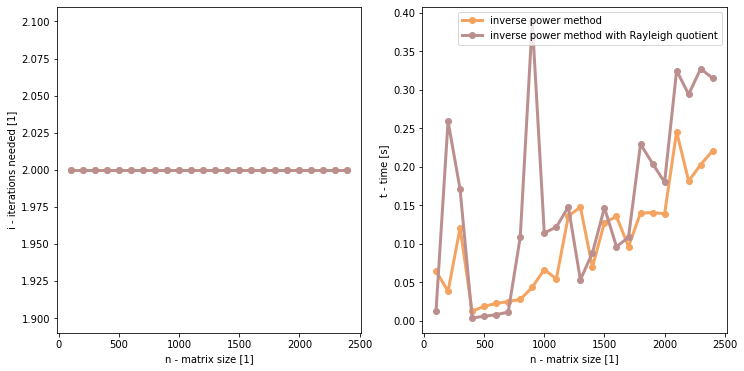

In [69]:
compare_convergence()

W powyższych testach, sigma została dobrana tak, aby mieć pewność, że jest blisko wartości własnej. W tym celu wykorzystałem zwykłą metodę potęgową do znalezienia tej wartości. W tym przypadku liczba iteracji była zawsze równa 2, przez co można wnioskować że obydwie metody są bardzo skuteczne jeśli dobrze dobierzemy wartość sigma. Otrzymane czasy, mimo tej samej liczby iteracji, są zróżnicowane nie tylko pomiędzy metodami, ale także w ich obrębie. Można jednak przypuszczać, iż metoda z ilorazem Rayleigha jest statystycznie wolniejsza.

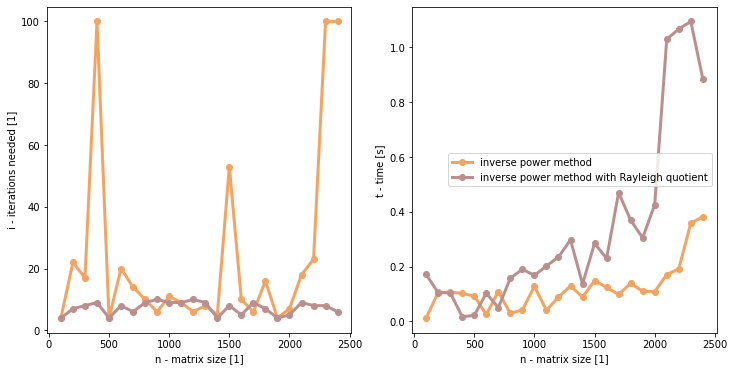

In [54]:
compare_convergence(sigma=0)

Powyżej dokonałem testów, przyjmując stałą liczbę sigma. Przez to liczba iteracji jest zróżnicowana, w zależności głównie od tego, jak blisko od jednej wartości własnej i daleko od pozostałych okazało się leżeć sigma. Wyraźnie widać, iż metoda wykorzystująca iloraz Rayleigha dużo lepiej poradziła sobie w tym przypadku, jeśli chodzi o liczbę potrzebnych iteracji. Jednak, mimo szybszej zbieżności, czas działania funkcji był zauważalnie większy niż dla zwykłej odwrotnej metody potęgowej. Wynika to z różnicy w złożoności czasowej procedury rozwiązywania układów równań. W metodzie standardowej, dzięki pojedynczej faktoryzacji LU byliśmy w stanie szybciej rozwiązać układ, a ponadto metoda wymaga mniejszej liczby operacji.

## Wnioski

- Jesteśmy w stanie w stosunkowo szybki sposób znajdować przybliżenia wartości i wektorów własnych, w szczególności jeśli interesuje nas tylko największa wartość, lub najbliższa danej liczby.
- Wykorzystanie ilorazy Rayleigha w odwrotnej metodzie potęgowej pozwala zmniejszyć liczbę iteracji, lecz często nie prowadzi to do zmniejszenia czasu działania procedury.

M. Hawryluk 11.05.2021